In [1]:
import os, glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [18]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
suffix, sep = 'txt', '\t'
meas_dict = {}
for fname in glob.glob(f'./measurements/*.{suffix}'):
    with open(fname) as file:
        meas = [[float(el) for el in row.rstrip().split(sep)]
                for row in file.readlines()]
        meas_name, _ = str.rsplit(os.path.basename(fname), '.', maxsplit=1)
        meas_dict[meas_name] = np.array(meas).T

In [6]:
meas_dict.keys()

dict_keys(['j-by-beta-1', 'j-by-alpha-1', 'j-by-U-2', 'j-by-beta-2', 'j-by-alpha-2', 'j-by-U-1'])

In [7]:
def f_α(x, I_1, I_0, δ):
    return I_1*np.cos(x - δ)**2 + I_0

def f_β(x, I_1, I_0, δ):
    return I_1*np.sin(2*x - δ)**2 + I_0

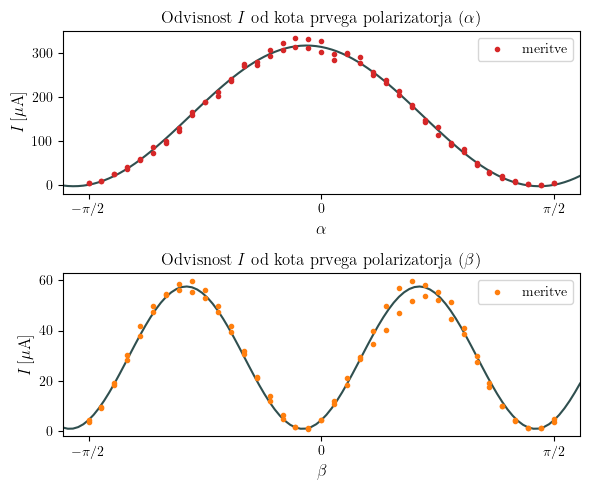

In [8]:
α_0 = β_0 = np.deg2rad(-90)
α, I_α = np.concatenate(
    [meas_dict['j-by-alpha-1'],
     meas_dict['j-by-alpha-2']],
    axis=1)
α = np.deg2rad(α*5) + α_0
β, I_β = np.concatenate(
    [meas_dict['j-by-beta-1'],
     meas_dict['j-by-beta-2']],
    axis=1)
β = np.deg2rad(β*5) + β_0

par, cov = curve_fit(f_α, α, I_α, p0=[320, 0, 0])
I_1α, I_0α, δ_α = par
σ_I_1α, σ_I_0α, σ_δ_α = np.sqrt(np.diag(cov))

par, cov = curve_fit(f_β, β, I_β, p0=[50, 0, 0])
I_1β, I_0β, δ_β = par
σ_I_1β, σ_I_0β, σ_δ_β = np.sqrt(np.diag(cov))

# Plot.
fig, axs = plt.subplots(2, 1, figsize=[6, 5])
axs[0].scatter(α, 1e6 * I_α, marker='.', label=r'meritve', color='tab:red')
axs[1].scatter(β, 1e6 * I_β, marker='.', label=r'meritve', color='tab:orange')

x_lin = np.linspace(-np.deg2rad(100), np.deg2rad(100), num=101)
axs[0].plot(x_lin, 1e6 * f_α(x_lin, I_1α, I_0α, δ_α), color='darkslategrey', zorder=-1)
axs[1].plot(x_lin, 1e6 * f_β(x_lin, I_1β, I_0β, δ_β), color='darkslategrey', zorder=-1)

axs[0].set_title(r'Odvisnost $I$ od kota prvega polarizatorja ($\alpha$)')
axs[0].set_xlabel(r'$\alpha$')
axs[1].set_title(r'Odvisnost $I$ od kota prvega polarizatorja ($\beta$)')
axs[1].set_xlabel(r'$\beta$')
for ax in axs:
    ax.set_ylabel(r'$I\,[\mathrm{\mu A}]$')
    ax.set_xlim((-np.deg2rad(100), np.deg2rad(100)))
    ax.set_xticks([-np.pi/2, 0, np.pi/2])
    ax.set_xticklabels(['$-\pi/2$', r'$0$', r'$\pi/2$'])
    ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('I-by-angle.pdf')

In [9]:
1e6 * I_1α, 1e6 * σ_I_1α, 1e6 * I_0α, 1e6 * σ_I_0α, np.rad2deg(δ_α), np.rad2deg(σ_δ_α)

(319.6610771852818,
 2.3625369280091286,
 -2.247108799340307,
 1.4271156517526937,
 -5.72675680152402,
 0.21692582548966857)

In [10]:
1e6 * I_1β, 1e6 * σ_I_1β, 1e6 * I_0β, 1e6 * σ_I_0β, np.rad2deg(δ_β), np.rad2deg(σ_δ_β)

(56.42520935153476,
 0.6811659169105976,
 1.02215062003204,
 0.41157858685402166,
 -14.337482182736487,
 0.35078312200990003)

In [11]:
def g(U, I_1, B, ϕ_0):
    return I_1*np.sin(np.pi*B*L/d**2 * U**2 + ϕ_0/2)**2

91.6, 1.5, 1.17, 0.04, -44, 4
91.3, 0.6, 1.29, 0.02, -60, 3


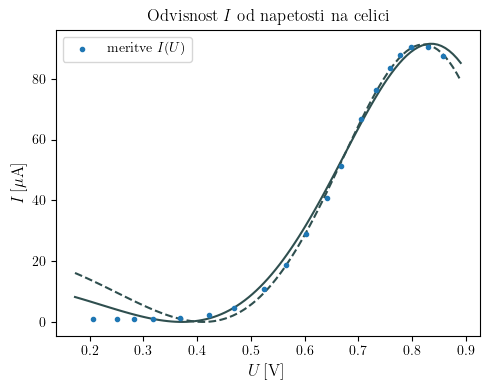

In [13]:
L = 1.5e-3
d = 1.4e-3
U, I = meas_dict['j-by-U-2']

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 4])
ax.scatter(U, 1e6 * I, marker='.', label=r'meritve $I(U)$')

U_lin = np.linspace(*ax.get_xlim(), num=101)
for n, style in zip([0, 5], ['solid', 'dashed']):
    par, cov = curve_fit(g, U[n:], I[n:], p0=[80e-6, 1e-3, 0])
    I_1, B, ϕ_0 = par
    σ_I_1, σ_B, σ_ϕ_0 = np.sqrt(np.diag(cov))
    print(f'{1e6 * I_1:.1f}, {1e6 * σ_I_1:.1f}, {1e3 * B:.2f}, {1e3 * σ_B:.2f}, {np.rad2deg(ϕ_0):.0f}, {np.rad2deg(σ_ϕ_0):.0f}')
    ax.plot(U_lin, 1e6 * g(U_lin, I_1, B, ϕ_0+2*np.pi), color='darkslategrey', linestyle=style, zorder=-1)

ax.set_title(r'Odvisnost $I$ od napetosti na celici')
ax.set_xlabel(r'$U\,[\mathrm{V}]$')
ax.set_ylabel(r'$I\,[\mathrm{\mu A}]$')
ax.legend()
fig.tight_layout()
fig.savefig('I-by-U.pdf')